In [1]:
import pandas as pd
import numpy  as np

import data file

In [2]:
df = pd.read_csv('data_new.csv')
df.describe()

,Label
count,329.000000
mean,0.589666
std,0.492644
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


split data

In [3]:
print("Non-cheat: ", len(df[df['Label']==0]))
print("Cheat: ", len(df[df['Label']==1]))

# diff = abs(len(df[df['Label']==0]) - len(df[df['Label']==1]))

grouped = df.groupby(df.Label)
df1 = grouped.get_group(1)
df2 = grouped.get_group(0)

df2_1 = df.iloc[:135,:]
df2_2 = df.iloc[135:194,:]

df1_train = df1.iloc[:111,:]
df2_train = df2_1.iloc[:111,:]

df1_test = df1.iloc[111:135,:]
df2_test = df2_1.iloc[111:135,:]

train = pd.concat([df1_train, df2_train])
test  = pd.concat([df1_test, df2_test, df2_2])

print((len(train), len(test)))

Non-cheat:  135
Cheat:  194
(222, 107)


parse data from string to numpy array

In [4]:
def parseData(series):
    final_series = []
    for ser in series:
        temp = []
        for x in "[],":
            ser = ser.replace(x, "")
        new_ser  = np.fromstring(ser, dtype=float, sep=" ")
        for i in range(0, len(new_ser), 3):
            chunk = [new_ser[i], new_ser[i + 1], new_ser[i + 2]]
            temp.append(chunk)
        final_series.append(temp)
    return np.array(final_series, dtype=object)

get the longest sequence of vector in dataset

In [5]:
max_length = 0
for lgaze in parseData(df['Left Gaze']):
    if len(lgaze) > max_length:
        max_length = len(lgaze)
        
max_length

1294

pad the dataset to the longest sequence size

In [6]:
import math

def padData(series, length):
    for idx, ser in enumerate(series):
        times = math.floor(length / len(ser))
        add = length % len(ser)
        
        temp = ser[::-1]
        for _ in range(1, times):
            series[idx] = np.append(series[idx], temp, axis=0)
            temp = temp[::-1]
        if add != 0:
            series[idx] = np.append(series[idx], temp[0:add], axis=0)
    return series

(AlexNet_1D)Conv1D -> AveragePooling1D -> Conv1D -> AveragePooling1D -> Conv1D -> Conv1D -> Conv1D -> AveragePooling1D -> LSTM -> Dense -> Dropout -> Dense

In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, AveragePooling1D, MaxPooling1D, LSTM, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, History

import tensorflow as tf

def init_model():
    model = Sequential()
    model.add(Conv1D(filters=12, kernel_size=3,strides=2, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2, strides = 2))
    model.add(Conv1D(filters=32, kernel_size=3,strides=1, padding="same", activation='relu', input_shape=(max_length, 12)))
    # model.add(Conv1D(filters=32, kernel_size=3, padding="same", activation='relu'))
    model.add(AveragePooling1D(pool_size=2, strides= 2))
    # model.add(Conv1D(filters=12, kernel_size=3,strides=2, padding="same", activation='relu', input_shape=(max_length, 12)))
    # model.add(Conv1D(filters=12, kernel_size=3,strides=2, padding="same", activation='relu', input_shape=(max_length, 12)))
    # model.add(Conv1D(filters=12, kernel_size=3,strides=2, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(Conv1D(filters=48, kernel_size=3,strides=1, padding="same", activation='relu'))
    model.add(Conv1D(filters=48, kernel_size=3,strides=1, padding="same", activation='relu'))
    model.add(Conv1D(filters=32, kernel_size=3,strides=1, padding="same", activation='relu'))
    model.add(AveragePooling1D(pool_size=2))
    model.add(LSTM(12))
    # adam = optimizers.legacy.Adam(lr=0.001, beta_1=0, beta_2=0, epsilon=None, decay=0.0)
    adam = optimizers.legacy.Adam(lr=0.001, beta_1=0.1, beta_2=0.9, epsilon=None, decay=0.0)
    
    model.add(Flatten())
    model.add(Dense(512, activation = 'softmax')) 
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = 'softmax')) 
    model.add(Dense(2, activation = 'softmax'))# We have only 2 classes: Non-cheat & Cheat\n",
    model.compile(optimizer=adam, loss='categorical_crossentropy',
                      metrics=['accuracy'])
   
    return model


In [73]:
right_gaze_train = train["Right Gaze"]
left_gaze_train  = train["Left Gaze"]
right_head_train = train["Right HeadPose"]
left_head_train  = train["Left HeadPose"]
label_train = train['Label']

right_gaze_train, left_gaze_train, right_head_train, left_head_train = parseData(right_gaze_train), parseData(left_gaze_train), parseData(right_head_train), parseData(left_head_train)

initialize new data frame

In [74]:
left_head_train  = padData(left_head_train,  max_length)
right_head_train = padData(right_head_train, max_length)
left_gaze_train  = padData(left_gaze_train,  max_length)
right_gaze_train = padData(right_gaze_train, max_length)

In [75]:
label_train = np.array(label_train)

In [76]:
y_train = []
for i in range(len(label_train)):
    y_train.append(
        tf.convert_to_tensor(
            np.reshape(tf.keras.utils.to_categorical(label_train[i], num_classes=2), (1, 2))                 
                            )
             )
    
y_train = tf.convert_to_tensor(np.vstack(y_train), dtype=tf.float32)

In [78]:
x_train = []

for i in range(len(left_gaze_train)):
    x_train.append(tf.convert_to_tensor([
                                            np.hstack(
                                                        (left_gaze_train[i], right_gaze_train[i], left_head_train[i], right_head_train[i])
                                                     )
                                            ], dtype=tf.float32))



x_train = tf.convert_to_tensor(np.vstack(x_train), dtype=tf.float32)

# print(x_train)

# print(y_train)

Train the model

In [79]:
right_gaze_test = test["Right Gaze"]
left_gaze_test  = test["Left Gaze"]
right_head_test = test["Right HeadPose"]
left_head_test  = test["Left HeadPose"]
label_test = test['Label']
label_test = np.array(label_test)

right_gaze_test, left_gaze_test, right_head_test, left_head_test = parseData(right_gaze_test), parseData(left_gaze_test), parseData(right_head_test), parseData(left_head_test)

In [80]:
left_head_test  = padData(left_head_test,  max_length)
right_head_test = padData(right_head_test, max_length)
left_gaze_test  = padData(left_gaze_test,  max_length)
right_gaze_test = padData(right_gaze_test, max_length)

In [81]:
x_test = []
y_test = []
for i in range(len(left_gaze_test)):
    x_test.append(tf.convert_to_tensor([
                                            np.hstack(
                                                        (left_gaze_test[i], right_gaze_test[i], left_head_test[i], right_head_test[i])
                                                     )
                                            ], dtype=tf.float32))                                        
for i in range(len(label_test)):
    y_test.append(
        tf.convert_to_tensor(np.reshape(tf.keras.utils.to_categorical(label_test[i], num_classes=2), (1, 2)))
             )
    
x_test = tf.convert_to_tensor(np.vstack(x_test), dtype=tf.float32)
y_test = tf.convert_to_tensor(np.vstack(label_test), dtype=tf.float32)
print(x_test.shape, y_test.shape)

(107, 1294, 12) (107, 1)


In [96]:
model = init_model()
callbacks = [EarlyStopping(monitor='loss', patience=3), History()]
history = model.fit(x_train, y_train,validation_split=0.1, epochs=200, batch_size=128, callbacks=callbacks)

Epoch 1/200


C:\conda\Lib\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2/2 [==============================] - 4s 847ms/step - loss: 0.6916 - accuracy: 0.7940 - val_loss: 0.6887 - val_accuracy: 0.8696
Epoch 2/200
2/2 [==============================] - 0s 87ms/step - loss: 0.6891 - accuracy: 0.7940 - val_loss: 0.6856 - val_accuracy: 0.8696
Epoch 3/200
2/2 [==============================] - 0s 85ms/step - loss: 0.6868 - accuracy: 0.7940 - val_loss: 0.6828 - val_accuracy: 0.8696
Epoch 4/200
2/2 [==============================] - 0s 89ms/step - loss: 0.6845 - accuracy: 0.7940 - val_loss: 0.6798 - val_accuracy: 0.8696
Epoch 5/200
2/2 [==============================] - 0s 87ms/step - loss: 0.6822 - accuracy: 0.7940 - val_loss: 0.6769 - val_accuracy: 0.8696
Epoch 6/200
2/2 [==============================] - 0s 91ms/step - loss: 0.6799 - accuracy: 0.7940 - val_loss: 0.6741 - val_accuracy: 0.8696
Epoch 7/200
2/2 [==============================] - 0s 91ms/step - loss: 0.6777 - accuracy: 0.7940 - val_loss: 0.6714 - val_accuracy: 0.8696
Epoch 8/200
2/2 [==============

In [90]:
for layer in model.layers:
    print(layer.output_shape)

(None, 1294, 12)
(None, 647, 12)
(None, 647, 12)
(None, 647, 32)
(None, 323, 32)
(None, 323, 12)
(None, 323, 12)
(None, 323, 12)
(None, 323, 48)
(None, 323, 48)
(None, 323, 32)
(None, 161, 32)
(None, 12)
(None, 12)
(None, 512)
(None, 512)
(None, 2)


Predict test set

In [97]:
results = model.evaluate(x_test, y_test, batch_size=128)
print(results)
predictions = model.predict(x_test)

label_predictions = []

# convert from category to label
for prediction in predictions:
    if prediction[0] > prediction[1]:
        label_predictions.append(0)
    else: label_predictions.append(1)
    
label_predictions = np.array(label_predictions)
label_test = np.array(label_test)

print(label_predictions)
print(label_test)

# calc acc
true_count = 0
for idx, label in enumerate(label_predictions):
    if label == label_test[idx]:
        true_count += 1
        
print("Accuracy on test set: ", true_count/(len(label_test)))

1/1 [==============================] - 1s 822ms/step - loss: 1.2427 - accuracy: 0.0000e+00
[1.2427231073379517, 0.0]
4/4 [==============================] - 1s 10ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 0 1 0
 0 0 1 1 0 0 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1
 1 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 0 1 0 1 0 0]
Accuracy on test set:  0.6915887850467289


In [92]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [86]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

plot the loss and acc from training process

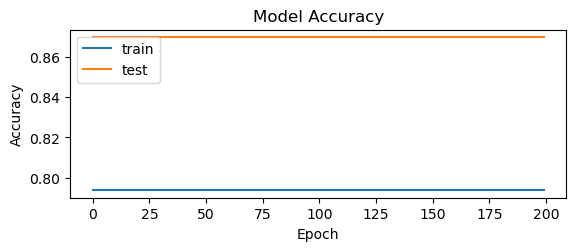

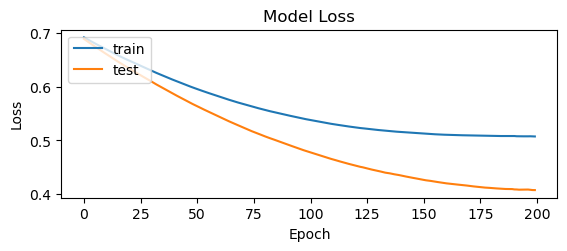

In [98]:
from matplotlib import pyplot as plt
# Plot accuracy
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot loss
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()